### Two transmon optimisation with cosine signal
Same as two_transmons_4LOs.ipynb, but the signal is created by a superposition of cosines. This can be used to optimise a large superposition of frequency peaks.

In [1]:
import argparse
import copy
import os
import sys

import numpy as np
import scipy.linalg
import tensorflow as tf

import c3
import c3.libraries.algorithms as algorithms
import c3.libraries.fidelities as fidelities
import c3.utils.qt_utils as qt_utils
from c3.signal.pulse import EnvelopeDrag
from c3.utils.tf_utils import tf_project_to_comp
import four_level_transmons.custom_gates as custom_gates
from c3.experiment import Experiment as Exp
from c3.model import Model as Mdl
from c3.optimizers.optimalcontrol import OptimalControl
from c3.parametermap import ParameterMap as PMap
from four_level_transmons.DataOutput import DataOutput
from four_level_transmons.custom_envelopes import *
from four_level_transmons.plotting import *
from four_level_transmons.utilities import *
from four_level_transmons.blackbox import generateSignalFromConfig
from four_level_transmons.notebook_utils import *
tf.config.run_functions_eagerly(True)
np.set_printoptions(linewidth=300)

2022-10-27 10:47:35.710869: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-27 10:47:35.710894: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
FREQS = None
INPUT_FILE = None
if len(sys.argv[1:]) > 3 and "ipykernel_launcher" not in sys.argv[0]:
    parser = argparse.ArgumentParser()
    parser.add_argument("--output", help="Output directory")
    parser.add_argument("--config", help="File with previous configuration")
    parser.add_argument("--freqs1", help="New number of frequencies on qubit1")
    parser.add_argument("--freqs2", help="New number of frequencies on qubit2")
    args = parser.parse_args()
    output_dir = args.output
    INPUT_FILE = args.config
    FREQS = (int(args.freqs1), int(args.freqs2))
    print("Output directory: ", output_dir)
    print("Number of frequencies: ", FREQS)
elif len(sys.argv[1:]) > 0 and "ipykernel_launcher" not in sys.argv[0]:
    parser = argparse.ArgumentParser()
    parser.add_argument("--output", help="Output directory")
    args = parser.parse_args()
    output_dir = args.output
    print("Output directory: ", output_dir)
else:
    print("=========== WARNING: no output directory specified ============")
    output_dir = "./output"
output = DataOutput(output_dir, file_suffix='before')

=========== WARNING: no output directory specified ============


In [47]:
# general settings
numPWCPieces = 60
usePWC = False
useDRAG = False
t_final = 200e-9 #1e-11
sim_res = 20e9 #1000e9
awg_res = numPWCPieces / t_final if usePWC else 50e9 #1000e9
isDressed = True
useFR = False

ALGORITHM_LBFGS = 0
ALGORITHM_LBFGS_GRAD_FREE = 1
ALGORITHM_CMAES = 2
ALGORITHM_GCMAES = 3
selected_algorithms = [
    #(ALGORITHM_LBFGS, {"maxfun": 50}),
    #(ALGORITHM_CMAES, {}),
    (ALGORITHM_LBFGS, {"maxfun": 1500, "ftol": 2e-6})
]

In [48]:
if INPUT_FILE is None:
    #INPUT_FILE = "./optimised_params/CCCX_1110-1111_200ns_full.json"
    #INPUT_FILE = "./optimised_params/fourier basis 5 levels/100 freqs/unity.json"
    INPUT_FILE = "./optimised_params/fourier basis 5 levels, 500ns, RF/full spectrum/CNOT.json"
#IDEAL_GATE, IDEAL_GATE_NAME = np.eye(16), "unity"
IDEAL_GATE, IDEAL_GATE_NAME = custom_gates.GATE_CNOT_t1q2_t2q2, "cnot_t1q2_t2q2"
#IDEAL_GATE, IDEAL_GATE_NAME = custom_gates.GATE_iCNOT_t1q2_t2q2, "icnot_t1q2_t2q2"
#IDEAL_GATE, IDEAL_GATE_NAME = custom_gates.GATE_iSWAP_t1q2_t2q2, "iswap_t1q2_t2q2"
#IDEAL_GATE, IDEAL_GATE_NAME = custom_gates.GATE_SQRTiSWAP_t1q2_t2q2, "sqrtiswap_t1q2_t2q2"
#IDEAL_GATE, IDEAL_GATE_NAME = custom_gates.GATE_CZ_t1q2_t2q2, "cz_t1_t2"
#IDEAL_GATE, IDEAL_GATE_NAME = custom_gates.GATE_UNIVERSAL_ENTANGLER, "universal_entangler"
#IDEAL_GATE, IDEAL_GATE_NAME = custom_gates.GATE_4QUBIT_1110_1111, "cccnot_1110"

OPTIMISE_TFINAL = False
FORCE_XY_ANGLE = False
FORCE_FREQ_OFFSET = False
FORCE_DELTA = 0.0
OPTIMISE_FREQUENCIES = True

#NUM_PEAKS = (-1, 15)
#INCLUDED_INDICES = ([1,2,3,4,5,6,7,8,9,10,11,12,13,14], None)

if FREQS is not None:
    NUM_PEAKS = FREQS
else:
    NUM_PEAKS = (200, 200)
#NUM_PEAKS = (-1, -1)
INCLUDED_INDICES = (None, None)
#INCLUDED_INDICES = (np.array([1,2,3,4,5,6,7,8,9,10,11,12]), None)

#SPECTRAL_RANGE = (0.1e9, 5.5e9)
#SPECTRAL_RANGE = (2.5e9, 5.5e9)
SPECTRAL_RANGE = (-1, -1)
SELECTED_INDEX = (-1, -1)

OPTIMISABLE_DRIVES = [0, 1]

In [49]:
entanglementInitState = [0, 1]
entanglementInitStateFull = [0, 1]


def stateEntropyAB(state: tf.Tensor):
    rho = densityMatrix(state)
    if state.shape[0] > 16:
        rho = tf_project_to_comp(rho, dims=qubit_levels, outdims=[4, 4])
    rhoBD = tf_project_to_comp(rho, dims=[2, 2, 2, 2], outdims=[0, 2, 0, 2])
    #rhoBD = partialTrace(rho, [1, 3])
    rhoB = partialTrace(rhoBD, [0])
    #rhoAB = partialTrace(rho, [0, 1])
    return entanglementEntropy(rhoB)  #- entanglementEntropy(rhoBD)


def printEntanglementEvolution(exper: Experiment, gate: gates.Instruction, output: DataOutput):
    entropies = []
    #for state in [(0, 1), (0, 5), (1, 6), (5, 6)]:
    for state in [(0, 1), (0, 4), (1, 5), (4, 5)]:
        #for state in [(0, 4), (5, 6), (10, 11), (12, 13)]:
        psi_init = np.zeros(shape=(model.tot_dim,))
        psi_init[state[0]] = psi_init[state[1]] = 1 / np.sqrt(2)
        entropy = calculateObservable(exper, np.array(psi_init), [gate.get_key()], stateEntropyAB)
        entropies.append(entropy)
    entropies = np.array(entropies)
    plotPopulation(exper, entropies, sequence=[gate.get_key()],
                   labels=["00+01", "00+10", "01+11", "10+11"],
                   filename=output.createFileName("entanglement", "svg"),
                   labelY="Entropy")


'''
def entanglementStateGoal(actual: tf.constant, index, dims, active_levels):
    dim = active_levels ** len(dims)
    actual_comp = tf_project_to_comp(
        actual, dims=dims, index=index, outdims=[active_levels] * len(dims)
    )
    entropies = []
    for state in [(0, 4)]: #, (0, 1), (1, 5), (4, 5)]:
        psi_init = [[0] * dim]
        psi_init[0][state[0]] = psi_init[0][state[1]] = 1.0 / np.sqrt(2)
        init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
        #psi = np.zeros((dim, 1))
        #psi[state[0], 0] = psi[state[1], 0] = 1 / np.sqrt(2)
        #psi_init = tf.constant(psi, dtype=actual_comp.dtype)
        #init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
        psi_actual = tf.matmul(actual_comp, init_state)
        rho = densityMatrix(psi_actual)

        # S(B) - S(BD)
        rhoBD = partialTrace(rho, [1, 3])
        #entropyBD = entanglementEntropy(rhoBD)
        rhoB = partialTrace(rhoBD, [0])
        entropyB = entanglementEntropy(rhoB)
        entropies.append(entropyB)

        # S(AB)
        #rhoAB = partialTrace(rho, [0, 1])
        #entropies.append(entanglementEntropy(rhoAB) / 2)
    return 1 - np.max(entropies)
'''

def entanglementStateGoalTF(actual: tf.constant, index, dims, active_levels):
    dim = active_levels ** len(dims)
    actual_comp = tf_project_to_comp(
        actual, dims=dims, index=index, outdims=[active_levels] * len(dims)
    )

    # initial and final state
    psi = np.zeros((dim, 1))
    for i in entanglementInitState:
        psi[i, 0] = 1
    psi /= np.linalg.norm(psi)
    psi_init = tf.constant(psi, dtype=actual_comp.dtype)
    psi_actual = tf.matmul(actual_comp, psi_init)
    rho = densityMatrixTF(psi_actual[:, 0])

    # calculate entropy
    rhoBD = tf_project_to_comp(rho, dims=[2, 2, 2, 2], outdims=[0, 2, 0, 2])
    #rhoBD = partialTraceTF(rho, [1, 3])
    #entropyBD = entanglementEntropyTF(rhoBD) / 2
    rhoB = partialTraceTF(rhoBD, [0])
    entropyB = entanglementEntropyTF(rhoB)
    #return (1.0 - entropyB + entropyBD) + 0.5 * (1.0 - tf.math.real(tf.norm(psi_actual)))
    return (1.0 - entropyB) + 0.5 * (1.0 - tf.math.real(tf.norm(psi_actual)))

    #rhoAB = partialTraceTF(rho, [0, 1])
    #entropyAB = entanglementEntropyTF(rhoAB)
    #return (2.0 - entropyAB) + 0.5 * (1.0 - tf.math.real(tf.norm(psi_actual)))


def transmonEntanglementGoal(actual: tf.constant, index, dims, active_levels):
    actual_comp = tf_project_to_comp(
        actual, dims=dims, index=index, outdims=[active_levels] * len(dims)
    )
    rho = tf.einsum('ijkj->ik', tf.reshape(actual_comp, shape=[4,4,4,4]))
    entropy = entanglementEntropyTF(rho)
    return 1.0 - entropy


def entanglementGoal(propagators: dict, instructions: dict, index, dims, active_levels=2, n_eval=-1):
    infids = []
    for gate, propagator in propagators.items():
        infid = transmonEntanglementGoal(propagator, index, dims, active_levels)
        infids.append(infid)
    return tf.reduce_mean(infids)

In [50]:
# coupling=30: f=4.6, anh=-200; f=4.32, anh=-350
# f=4.5: anh=-200, coupling=33
# Initialise the qubits and drive lines
qubit_levels = [5, 5]
qubit_frequencies = [5e9, 4.5e9]
anharmonicities = [-300e6, -250e6]
t1s = [25e-6, 25e-6]
t2stars = [35e-6, 35e-6]
qubit_temps = [50e-3, 50e-3]
couplingStrength = 20e6
print("qubits frequencies: ", qubit_frequencies, "anharmonicities: ", anharmonicities,
      "coupling: ", couplingStrength)

level_labels_transmon = ["|0,0\\rangle", "|0,1\\rangle", "|1,0\\rangle", "|1,1\\rangle"]
for i in range(len(level_labels_transmon), max(qubit_levels)):
    level_labels_transmon.append("leakage")
level_labels = []
level_labels_with_leakage = []
level_labels_short = []
for i in range(qubit_levels[0]):
    for j in range(qubit_levels[1]):
        if i > 3 or j > 3:
            level_labels_with_leakage.append("leakage")
        else:
            s = f"${level_labels_transmon[i]},{level_labels_transmon[j]}$"
            level_labels.append(s)
            level_labels_with_leakage.append(s)
        level_labels_short.append(f"{i},{j}")
level_labels_transmon = [f"${x}$" for x in level_labels_transmon]

qubits = createQubits(qubit_levels, qubit_frequencies, anharmonicities,
                         t1s, t2stars, qubit_temps)
coupling = createChainCouplings([couplingStrength], qubits)
drives = createDrives(qubits)

qubits frequencies:  [5000000000.0, 4500000000.0] anharmonicities:  [-300000000.0, -250000000.0] coupling:  20000000.0


In [51]:
# Create the model
model = Mdl(qubits, coupling + drives)
model.set_lindbladian(False)
model.set_dressed(isDressed)
model.set_FR(useFR)

#energies = model.get_Hamiltonian().numpy().diagonal().real / (2 * np.pi)
#print("energies: ", energies)
qubitEnergies = [q.get_Hamiltonian().numpy().diagonal().real / (2 * np.pi) for q in qubits]
qubitEnergies[0] = qubitEnergies[0][::qubit_levels[0]]
qubitEnergies[1] = qubitEnergies[1][:qubit_levels[1]]
qubitTransitions = [np.array([e[i + 1] - e[i] for i in range(len(e) - 1)]) for e in qubitEnergies]
for i in range(len(qubits)):
    print(f"Qubit {i}:")
    print(qubitEnergies[i])
    print(qubitTransitions[i])

Qubit 0:
[0.00e+00 5.00e+09 9.70e+09 1.41e+10 1.82e+10]
[5.0e+09 4.7e+09 4.4e+09 4.1e+09]
Qubit 1:
[0.000e+00 4.500e+09 8.750e+09 1.275e+10 1.650e+10]
[4.50e+09 4.25e+09 4.00e+09 3.75e+09]


In [52]:
# all energy levels with labels
stateEnergies = []
H = model.get_Hamiltonian().numpy()
evals,evecs = scipy.linalg.eig(H)
evals = evals.real / (2 * np.pi)
indices = [np.argmax(np.round(evecs[i], 2)) for i in range(len(evals))]
for i, x in enumerate(level_labels_short):
    if x is not None:
        energy = evals[indices[i]]
        stateEnergies.append((energy, x))

# all energy transitions
items = sorted(stateEnergies, key=lambda x: x[0])
transitions = []
for i in range(len(items)):
    for j in range(len(items)):
        if i != j:
            #print(i, j)
            E = items[j][0] - items[i][0]
            if E > 0:
                transitions.append((E, items[i][1] + " - " + items[j][1]))
#for t in transitions:
#    print(t)

#transitions.sort(key=lambda x: x[0])
#for t in transitions:
#    print(t)

directTransitions = np.array([np.abs(stateEnergies[i + 1][0] - stateEnergies[i][0]) for i in range(0, len(stateEnergies) - 1, 1)])
#directTransitions = []
#for i in range(0, len(stateEnergies)-1, 1):
#    diff = stateEnergies[i+1][0] - stateEnergies[i][0]
#    directTransitions.append(diff)
#print(directTransitions)

In [53]:
def getFourierBasisFromDirectTransitions(qubitTransitions):
    allTransitions = [qubitTransitions[0][0], qubitTransitions[0][1], qubitTransitions[0][2], qubitTransitions[1][0], qubitTransitions[1][1], qubitTransitions[1][2]]
    allAmps = [0.2, 0.02, 0.2, 1, 0.1, 1]
    selectedFreqsMap = {"d1": np.array(allTransitions), "d2": np.array(allTransitions)}
    selectedAmpsMap = {"d1": 1e8 * np.array(allAmps), "d2": 1e7 * np.array(allAmps)}
    selectedPhasesMap = {"d1": np.zeros_like(allTransitions), "d2": np.zeros_like(allTransitions)}
    return selectedFreqsMap, selectedAmpsMap, selectedPhasesMap

def getFourierBasisFromModel(levelTransitions: List[float], spectralRange: Tuple[float,float]=(3.6e9,5.0e9)) -> Tuple[Dict, Dict, Dict]:
    selectedFrequencies = []
    for t in levelTransitions:
        if spectralRange[0] < t[0] < spectralRange[1]:
            selectedFrequencies.append(t[0])
    selectedFrequencies = np.sort(selectedFrequencies)
    selectedFreqsMap = {"d1": selectedFrequencies, "d2": selectedFrequencies}
    selectedAmpsMap = {"d1": 0.5e8 * np.ones_like(selectedFrequencies), "d2": 0.5e7 * np.ones_like(selectedFrequencies)}
    selectedPhasesMap = {"d1": 0.1 * np.ones_like(selectedFrequencies), "d2": 0.1 * np.ones_like(selectedFrequencies)}
    return selectedFreqsMap, selectedAmpsMap, selectedPhasesMap


def getFourierBasisFromSignal(filename: str) -> Tuple[Dict, Dict, Dict]:
    stored_pmap = PMap()
    stored_pmap.read_config(filename)
    stored_params = stored_pmap.asdict()[list(stored_pmap.asdict().keys())[0]]
    stored_signal = generateSignalFromConfig(stored_params, sim_res=sim_res, awg_res=numPWCPieces / t_final,
                                             useDRAG=False,
                                             usePWC=True, numPWCPieces=60, t_final=t_final)
    selectedFreqsMap = {}
    selectedAmpsMap = {}
    selectedPhasesMap = {}
    for i, drive in enumerate(list(stored_signal.keys())):
        signal = stored_signal[drive]

        ts = signal["ts"].numpy()
        values = signal["values"].numpy()
        freq = np.fft.rfftfreq(len(ts), ts[-1] / len(ts))[1:]
        freq_signal = np.fft.rfft(values)[1:]
        #freq = np.fft.rfftfreq(len(ts), ts[-1] / len(ts))
        #freq_signal = np.abs(np.fft.rfft(values))
        #peaks, amps = findFrequencyPeaks(signal["ts"].numpy(), signal["values"].numpy(), 50, normalise=True)
        selectedFreqsMap[drive] = freq
        selectedAmpsMap[drive] = np.abs(freq_signal)
        selectedPhasesMap[drive] = np.angle(freq_signal)
        print("selected frequencies: ", len(selectedFreqsMap[drive]))
        print(selectedFreqsMap[drive])
    return selectedFreqsMap, selectedAmpsMap, selectedPhasesMap


def getConfigurationFromFile(filename: str, spectralRange: Tuple[float, float], numPeaks: Tuple[int, int],
                             selectedIndex=(None, None), includedIndices=(None, None),
                             addFreqs: List[Tuple[float, float, float]] = None) -> Dict:
    stored_pmap = PMap()
    stored_pmap.read_config(filename)
    stored_params = stored_pmap.asdict()[list(stored_pmap.asdict().keys())[0]]
    driveChannels = stored_params["drive_channels"]
    for driveIdx, driveName in enumerate(driveChannels.keys()):
        envelope = driveChannels[driveName][f"envelope_{driveName}"]
        freqs = envelope.params["freqs"].get_value().numpy() / (2 * np.pi)
        amps = envelope.params["amps"].get_value().numpy()
        phases = envelope.params["phases"].get_value().numpy()

        # restrict to spectral range
        if spectralRange is not None and len(spectralRange) > 1 and spectralRange[0] >= 0 and spectralRange[1] >= 0:
            indices = np.all([freqs > spectralRange[0], freqs < spectralRange[1]], 0)
            freqs = freqs[indices]
            amps = amps[indices]
            phases = phases[indices]
            print(f"Drive {driveName}: after restriction to range: {len(indices)}")

        # find peaks
        #if numPeaks is not None and numPeaks > 0:
        #    peaks = find_peaks(amps)[0]
        #    freqs = freqs[peaks]
        #    amps = amps[peaks]
        #    phases = phases[peaks]
        #    print(f"Drive {driveName}: peaks found: {len(peaks)}")

        # use largest N peaks
        if numPeaks[driveIdx] is not None and numPeaks[driveIdx] > 0:
            selectedIndices = amps.argsort()[-numPeaks[driveIdx]:][::-1]
            freqs = freqs[selectedIndices]
            amps = amps[selectedIndices]
            phases = phases[selectedIndices]
            print(f"Drive {driveName}: num peaks {len(selectedIndices)}")
        elif numPeaks[driveIdx] == 0:
            freqs = np.array([])
            amps = np.array([])
            phases = np.array([])
            print(f"Drive {driveName}: empty")
        if selectedIndex[driveIdx] is not None and selectedIndex[driveIdx] >= 0:
            freqs = freqs[selectedIndex[driveIdx]:selectedIndex[driveIdx] + 1]
            amps = amps[selectedIndex[driveIdx]:selectedIndex[driveIdx] + 1]
            phases = phases[selectedIndex[driveIdx]:selectedIndex[driveIdx] + 1]
            print(f"Drive {driveName}: selected index {len(freqs)}")
        elif includedIndices[driveIdx] is not None:
            freqs = freqs[includedIndices[driveIdx]].flatten()
            amps = amps[includedIndices[driveIdx]].flatten()
            phases = phases[includedIndices[driveIdx]].flatten()
            print(f"Drive {driveName}: included indices {len(freqs)}")

        if addFreqs is not None and len(addFreqs) > 0: # and driveIdx == 0
            for freq,amp,phase in addFreqs:
                freqs = np.append(freqs, freq)
                amps = np.append(amps, amp)
                phases = np.append(phases, phase)
        envelope.params["freqs"] = Qty(value=freqs, min_val=0.95 * freqs, max_val=1.05 * freqs, unit="Hz 2pi")
        envelope.params["amps"] = Qty(value=amps, min_val=1e-2 * amps, max_val=1e2 * amps, unit="V")
        envelope.params["phases"] = Qty(value=phases, min_val=-np.pi * np.ones_like(phases),
                                        max_val=np.pi * np.ones_like(phases), unit="rad")

        if len(freqs) > 0:
            print(f"frequencies {driveName}: {freqs[0]:e} {freqs[-1]:e} {len(freqs)}")
    return stored_params


def createSpectralRange(limits: Tuple[float, float], num: int) -> Tuple[Dict, Dict, Dict]:
    freqs = np.linspace(limits[0], limits[1], num)
    selectedFreqsMap = {"d1": freqs, "d2": freqs}
    selectedAmpsMap = {"d1": np.ones_like(freqs) * 1e-4, "d2": np.ones_like(freqs) * 1e-4}
    selectedPhasesMap = {"d1": np.random.random(len(freqs)) * (2 * np.pi) - np.pi,
                         "d2": np.random.random(len(freqs)) * (2 * np.pi) - np.pi}
    return selectedFreqsMap, selectedAmpsMap, selectedPhasesMap


def createPeaks(frequencies: np.array) -> Tuple[Dict, Dict, Dict]:
    selectedFreqsMap = {"d1": frequencies, "d2": frequencies}
    selectedAmpsMap = {"d1": np.ones_like(frequencies) * 0.2, "d2": np.ones_like(frequencies) * 0.2}
    selectedPhasesMap = {"d1": np.random.random(len(frequencies)) * (2 * np.pi) - np.pi,
                         "d2": np.random.random(len(frequencies)) * (2 * np.pi) - np.pi}
    return selectedFreqsMap, selectedAmpsMap, selectedPhasesMap


stored_params = getConfigurationFromFile(INPUT_FILE, spectralRange=SPECTRAL_RANGE, numPeaks=NUM_PEAKS,
                                         selectedIndex=SELECTED_INDEX, includedIndices=INCLUDED_INDICES)
''', addFreqs=[
        (3.9442e9, 0.01, 0.0),  #|1,1>|1,0> -> |1,1>|1,1>
    ])
'''
#selectedFreqsMap, selectedAmpsMap, selectedPhasesMap = getFourierBasisFromSignal(INPUT_FILE)
#selectedFreqsMap, selectedAmpsMap, selectedPhasesMap = createSpectralRange(SPECTRAL_RANGE, 5000)
#selectedFreqsMap, selectedAmpsMap, selectedPhasesMap  = createPeaks(np.array([4.0e9 - 20e6, 4.0e9 + 20e6, 4.5e9 - 20e6, 4.5e9 + 20e6]))
#selectedFreqsMap, selectedAmpsMap, selectedPhasesMap  = createPeaks(directTransitions)

Drive d1: num peaks 200
frequencies d1: 3.941197e+09 4.145715e+09 200
Drive d2: num peaks 200
frequencies d2: 3.999183e+09 4.034371e+09 200


', addFreqs=[\n        (3.9442e9, 0.01, 0.0),  #|1,1>|1,0> -> |1,1>|1,1>\n    ])\n'

In [54]:
# Create the generator
generator = createGenerator(drives, sim_res=sim_res, awg_res=awg_res, highpass_cutoff_freq=-1, lowpass_cutoff_freq=-1, useWindow=False)

In [55]:
# Envelopes and carriers
#carrier_freqs = [1e-8, 1e-8]
carrier_freqs = [1e-5, 1e-5]
carrier_framechange = [0.00, 0.00]
pulse_t_final = [t_final, t_final]
pulse_sigmas = [t_final/5, t_final/5]
pulse_amps = [2.0, 0.04]
pulse_deltas = [0, 0]
pulse_xy_angles = [0.0, 0.0]
pulse_freq_offsets = [0.0, 0.0]

envelopes = []
envelopesForDrive = {d.name: [] for d in drives}
carriers = []
carriersForDrive = {d.name: [] for d in drives}

#selectedFreqsMap, selectedAmpsMap, selectedPhasesMap = getFourierBasisFromModel(transitions)
#stored_params = getConfigurationFromFile("./optimised_params/10freqsvariable_from15_CZ.json", spectralRange=(3.5e9, 5.5e9), numPeaks=10)
#selectedFreqsMap, selectedAmpsMap, selectedPhasesMap = getFourierBasisFromSignal(INPUT_FILE)
#selectedFreqs = np.array(np.abs(directTransitions))
#selectedAmps = np.ones_like(directTransitions) * 0.1
#selectedFreqs = np.array([1e9])
#selectedAmps = 0.1 * np.ones_like(selectedFreqs)
#selectedPhases = np.ones_like(selectedFreqs)
#print(selectedFreqs)
for idx in []:
    #N = len(selectedFreqsMap[drives[idx].name])
    selectedFreqs = selectedFreqsMap[drives[idx].name]#.get_value()
    selectedAmps = selectedAmpsMap[drives[idx].name]#.get_value()
    selectedPhases = selectedPhasesMap[drives[idx].name]#.get_value()
    N = len(selectedFreqs)
    #ampFactor = [4.0 / N * 1e-9] * 2
    #print(f"drive{idx}: ", selectedPeaks, ampFactor * selectedAmps)

    env = createSinePulse(
        frequencies=selectedFreqs,
        amplitudes=selectedAmps,
        phases=selectedPhases,
        t_final=pulse_t_final[idx],
        amp=pulse_amps[idx],
        delta=pulse_deltas[idx],
        xy_angle=pulse_xy_angles[idx],
        freq_off=pulse_freq_offsets[idx],
        useDrag=useDRAG
    )
    '''
    env = createGaussianPulse(
        t_final=pulse_t_final[idx],
        sigma=pulse_t_final[idx] / 300.0,
        amp=pulse_amps[idx],
        delta=pulse_deltas[idx],
        xy_angle=pulse_xy_angles[idx],
        freq_off=pulse_freq_offsets[idx],
        useDrag=useDRAG
    )
    '''
    #env = scaleGaussianEnvelope(env, 2.0)
    #env = createNoDriveEnvelope(t_final)
    if usePWC:
        env = convertToPWC(env, numPWCPieces)
    env.name = f"envelope_{drives[idx].name}"
    #env.params["amp"] = scaleQuantity(env.params["amp"], 0.5)
    envelopes.append(env)
    envelopesForDrive[drives[idx].name].append(env)

    carrier_parameters = {
        "freq": Qty(value=carrier_freqs[idx], min_val=0.98 * carrier_freqs[idx],
                    max_val=1.02 * carrier_freqs[idx], unit="Hz 2pi"),
        "framechange": Qty(value=carrier_framechange[idx], min_val=-np.pi, max_val=3 * np.pi, unit="rad"),
    }
    carrier = pulse.Carrier(
        name=f"carrier_{drives[idx].name}",
        desc="Frequency of the local oscillator",
        params=carrier_parameters,
    )
    carriers.append(carrier)
    carriersForDrive[drives[idx].name].append(carrier)

for idx in [0, 1]:
    driveName = drives[idx].name
    stored_params_d = stored_params["drive_channels"][driveName]
    env: pulse.Envelope = copy.deepcopy(stored_params_d[f"envelope_{driveName}"])
    if useDRAG and not isinstance(env, EnvelopeDrag):
        print("Converting to DRAG")
        env = convertToDRAG(env)
    elif not useDRAG and isinstance(env, EnvelopeDrag):
        print("Converting from DRAG")
        env = convertFromDRAG(env)
    #if env.params["t_final"].get_value() != t_final:
    #    env.params["amp"] = scaleQuantity(env.params["amp"], env.params["t_final"].get_value() / t_final)
    #    print("Signal scaled by ", env.params["t_final"].get_value() / t_final)
    #env.params["amp"] = scaleQuantity(env.params["amp"], 0.6)
    env.params["t_final"] = Qty(value=t_final, min_val=0.5*t_final, max_val=1.5*t_final, unit="s")
    if useDRAG and FORCE_DELTA:
        env.params["delta"] = Quantity(value=FORCE_DELTA, min_val=-5, max_val=5, unit="")
    if FORCE_FREQ_OFFSET:
        env.params["freq_offset"] = Qty(
            value=pulse_freq_offsets[idx],
            min_val=min(0.8 * pulse_freq_offsets[idx], 1.2 * pulse_freq_offsets[idx]) if pulse_freq_offsets[idx] != 0 else -1,
            max_val=max(0.8 * pulse_freq_offsets[idx], 1.2 * pulse_freq_offsets[idx]) if pulse_freq_offsets[idx] != 0 else 1,
            unit="Hz 2pi",
        )
    if FORCE_XY_ANGLE:
        env.params["xy_angle"] = Qty(value=pulse_xy_angles[idx], min_val=-1.5 * np.pi, max_val=2.5 * np.pi, unit="rad")
    envelopes.append(env)
    envelopesForDrive[driveName].append(env)

    #shift = df if dstIdx == 0 else -df
    carrier = copy.deepcopy(stored_params_d[f"carrier_{driveName}"])
    carrier.name = f"carrier_{driveName}"
    carriers.append(carrier)
    carriersForDrive[driveName].append(carrier)

#print("carrier: ", [[carrier.params["freq"] for carrier in carriers] for carriers in carriersForDrive.values()])
print("amp: ", [[env.params["amp"] for env in envelopes] for envelopes in envelopesForDrive.values()])

amp:  [[2.966 V], [40.365 mV]]


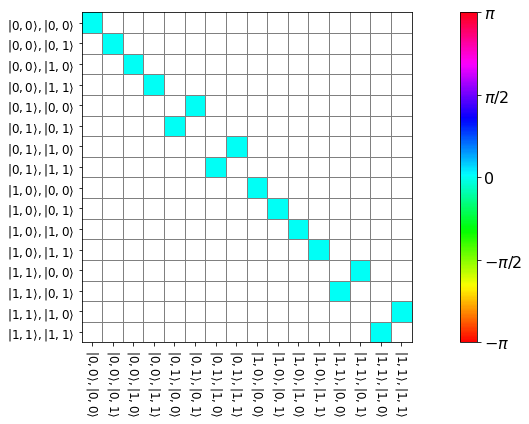

In [56]:
printMatrix(IDEAL_GATE, level_labels, "ideal_gate", output)

gate = gates.Instruction(
    name=IDEAL_GATE_NAME,
    #name="unity",
    targets=[0, 1],
    t_start=0.0,
    t_end=t_final,
    channels=[d.name for d in drives],
    ideal=IDEAL_GATE,
)
for drive in drives:
    for env in envelopesForDrive[drive.name]:
        gate.add_component(copy.deepcopy(env), drive.name)
    for carrier in carriersForDrive[drive.name]:
        gate.add_component(copy.deepcopy(carrier), drive.name)

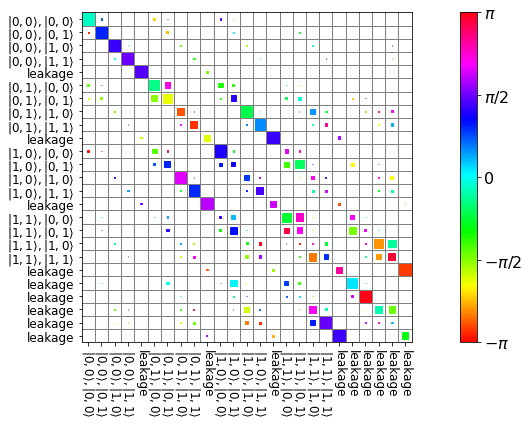

peaks: d1
	4.690586e+09 (amp=1.626866e+10)
	5.505688e+09 (amp=1.843397e+10)
	4.710589e+09 (amp=1.877034e+10)
	4.160520e+09 (amp=2.055042e+10)
	3.940493e+09 (amp=2.203829e+10)
	4.115514e+09 (amp=2.503877e+10)
	5.010626e+09 (amp=3.172508e+10)
	3.980498e+09 (amp=3.904528e+10)
	4.530566e+09 (amp=5.315077e+10)
	4.495562e+09 (amp=6.403572e+10)


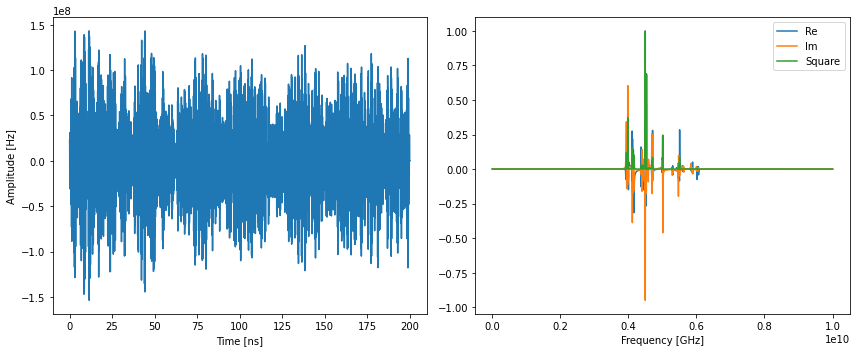

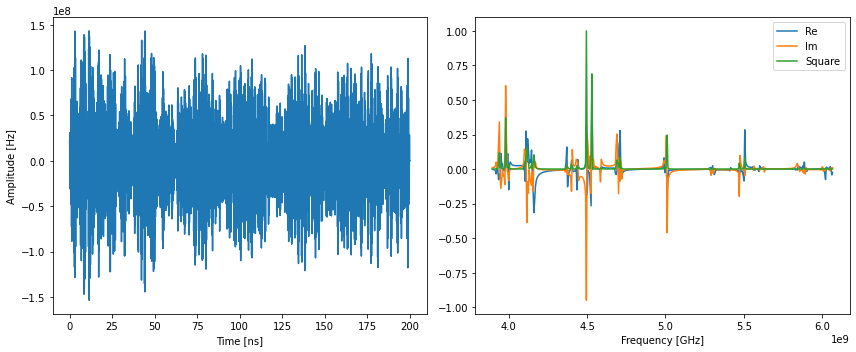

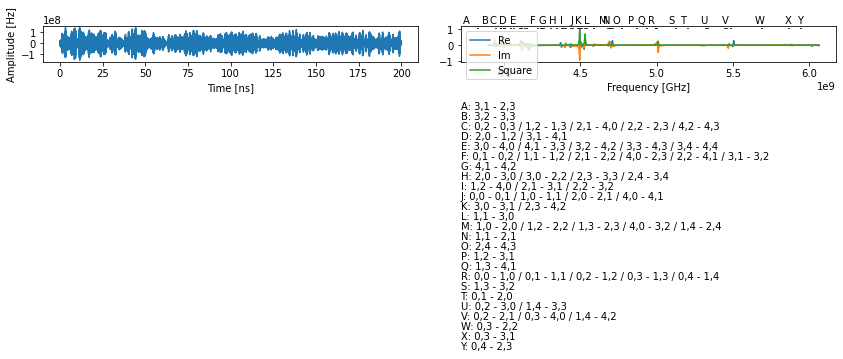

peaks: d2
	4.535567e+09 (amp=1.828604e+07)
	4.480560e+09 (amp=2.288227e+07)
	4.105513e+09 (amp=2.334965e+07)
	3.935492e+09 (amp=3.493867e+07)
	3.945493e+09 (amp=3.626342e+07)
	4.495562e+09 (amp=3.635446e+07)
	4.015502e+09 (amp=3.722599e+07)
	3.975497e+09 (amp=3.881498e+07)
	4.525566e+09 (amp=3.908790e+07)
	4.000500e+09 (amp=1.232358e+08)


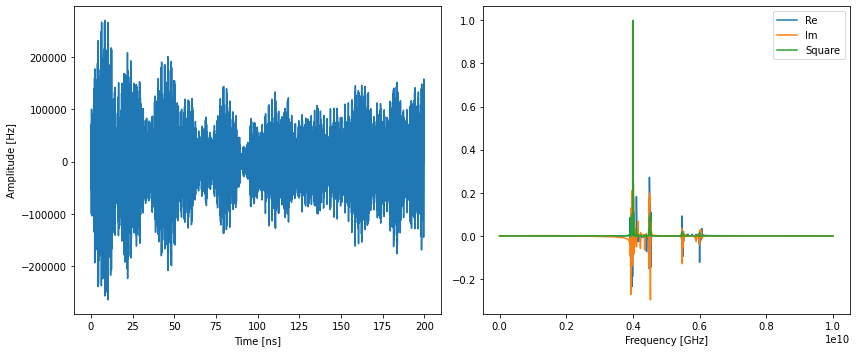

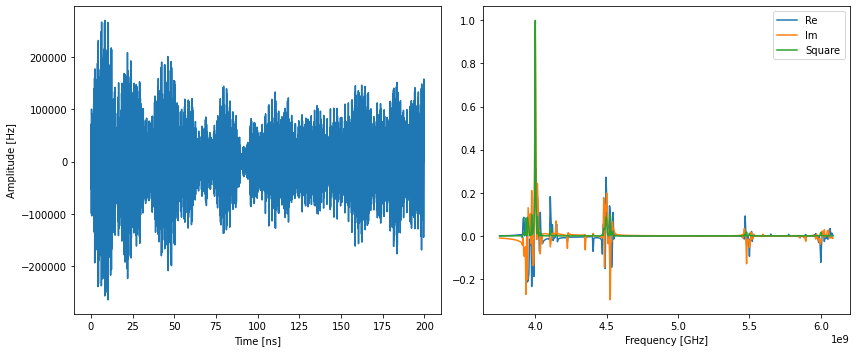

/home/user/c3/four_level_transmons/plotting.py:205: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


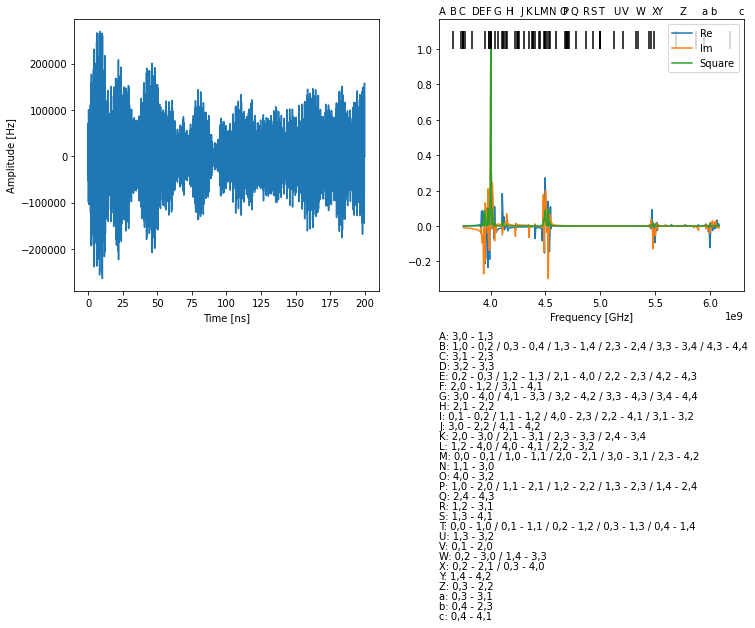

In [57]:
# Set up the experiment
parameter_map = PMap(instructions=[gate], model=model, generator=generator)
exp = Exp(pmap=parameter_map, sim_res=sim_res)
exp.set_opt_gates([gate.get_key()])

unitaries = exp.compute_propagators()
printPropagator(exp, gate, level_labels_with_leakage, output)
#printAllSignals(exp, qubits[0], output, directory="devices_before")
#printAllSignals(exp, qubits[1], output, directory="devices_before")
printSignal(exp, qubits, gate, output=output, states=transitions)

In [59]:
# Find all energy eigenvalues of the full Hamiltonian calculated from the propagator over short times
U = unitaries[gate.get_key()].numpy()
interval = 1e-12
tau = t_final / interval
U = np.float_power(U, 1.0 / tau)
diag = np.diagonal(U)
#print(diag)
energies = -np.angle(diag) / (2 * np.pi * interval)
print(energies)

'''
# all energy levels with labels
stateEnergies = zip(energies, level_labels_short)

# all energy transitions
items = sorted(stateEnergies, key=lambda x: x[0])
transitions = []
for i in range(len(items)):
    for j in range(len(items)):
        if i != j:
            E = items[j][0] - items[i][0]
            if E > 0:
                transitions.append((E, items[i][1] + " - " + items[j][1]))

transitions.sort(key=lambda x: x[0])
#for t in transitions:
#    print(t)

#directTransitions = np.array([np.abs(stateEnergies[i + 1][0] - stateEnergies[i][0]) for i in range(0, len(stateEnergies) - 1, 1)])
#directTransitions = []
#for i in range(0, len(stateEnergies)-1, 1):
#    diff = stateEnergies[i+1][0] - stateEnergies[i][0]
#    directTransitions.append(diff)
#print(directTransitions)
'''

[  148412.00680752  -772922.28959298 -1071194.90200277 -1246074.62046519 -1165002.44055928   369533.19417711  1569102.74196195  2210957.80433615  2341949.63751077  1549578.33015393  -995036.5934893   -934663.26973685  -699334.15380464 -1116787.95112795 -1550845.79483109   640846.94467558
 -1741682.4008503  -1903495.84423539  -724818.36585784 -2062913.50469068  -120131.93560627 -2495096.93613612   223968.41234903  -275142.88776265   761962.15698128]


'\n# all energy levels with labels\nstateEnergies = zip(energies, level_labels_short)\n\n# all energy transitions\nitems = sorted(stateEnergies, key=lambda x: x[0])\ntransitions = []\nfor i in range(len(items)):\n    for j in range(len(items)):\n        if i != j:\n            E = items[j][0] - items[i][0]\n            if E > 0:\n                transitions.append((E, items[i][1] + " - " + items[j][1]))\n\ntransitions.sort(key=lambda x: x[0])\n#for t in transitions:\n#    print(t)\n\n#directTransitions = np.array([np.abs(stateEnergies[i + 1][0] - stateEnergies[i][0]) for i in range(0, len(stateEnergies) - 1, 1)])\n#directTransitions = []\n#for i in range(0, len(stateEnergies)-1, 1):\n#    diff = stateEnergies[i+1][0] - stateEnergies[i][0]\n#    directTransitions.append(diff)\n#print(directTransitions)\n'

In [ ]:
# Specify the initial state
psi_init = [[0] * model.tot_dim]
for i in entanglementInitStateFull:
    psi_init[0][i] = 1
psi_init /= np.linalg.norm(psi_init)
print("initial state: ", psi_init)
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
sequence = [gate.get_key()]

#printTimeEvolution(exp, init_state, gate, level_labels, output)
#printEntanglementEvolution(exp, gate, output)
parameter_map.write_config(output.createFileName("parameter_map", "json"))

In [ ]:
# Specify the parameters to be optimised and initialise the optimiser
opt_map = []
for drive in [drives[i] for i in OPTIMISABLE_DRIVES]:
    for env in envelopesForDrive[drive.name]:
        opt_map.append([(gate.get_key(), drive.name, env.name, "amp")])
        #opt_map.append([(gate.get_key(), drive.name, env.name, "freq_offset")])
        opt_map.append([(gate.get_key(), drive.name, env.name, "xy_angle")])
        if useDRAG:
            opt_map.append([(gate.get_key(), drive.name, env.name, "delta")])
        if usePWC:
            opt_map.append([(gate.get_key(), drive.name, env.name, "inphase")])
            opt_map.append([(gate.get_key(), drive.name, env.name, "quadrature")])
            #opt_map.append([(gate.get_key(), drive.name, env.name, "t_bin_end")])
        else:
            opt_map.append([(gate.get_key(), drive.name, env.name, "amps")])
            if OPTIMISE_FREQUENCIES:
                opt_map.append([(gate.get_key(), drive.name, env.name, "freqs")])
            opt_map.append([(gate.get_key(), drive.name, env.name, "phases")])
            if OPTIMISE_TFINAL:
                opt_map.append([(gate.get_key(), drive.name, env.name, "t_final")])
    #for carrier in carriersForDrive[drive.name]:
    #    opt_map.append([(gate.get_key(), drive.name, carrier.name, "freq")])
    #    #opt_map.append([(gate.get_key(), drive.name, carrier.name, "framechange")])
parameter_map.set_opt_map(opt_map)
parameter_map.print_parameters()

In [ ]:
infidelities = []

for algorithm, params in selected_algorithms:
    if algorithm == ALGORITHM_LBFGS:
        infidelities = optimise(output, qubits, exp, algorithms.lbfgs, {
            "maxfun": 50,
            "ftol": 1e-5,
            **params
        }, gate)
    elif algorithm == ALGORITHM_LBFGS_GRAD_FREE:
        infidelities = optimise(output, qubits, exp, algorithms.lbfgs_grad_free, {
            "maxfun": 1000,
            "gtol": 1e-4,
            "ftol": 1e-4,
            **params
        }, gate)
    elif algorithm == ALGORITHM_CMAES:
        infidelities = optimise(output, qubits, exp, algorithms.cmaes, {
            "popsize": 15,
            "spread": 0.02,
            "maxfevals": 2000,
            "init_point": "True",
            "stop_at_sigma": 1e-3,
            "stop_at_convergence": 20,
            **params
        }, gate)
    elif algorithm == ALGORITHM_GCMAES:
        infidelities = optimise(output, qubits, exp, algorithms.gcmaes, {
            "cmaes": {"popsize": 12, "spread": 0.05, "maxfevals": 20,
                      "init_point": "True", "stop_at_sigma": 1e-4, "stop_at_convergence": 20, **params["cmaes"]},
            "lbfgs": {"maxfun": 500, "ftol": 1e-6, **params["lbfgs"]}
        }, gate)
    else:
        print("Unknown algorithm: ", algorithm)

In [ ]:
# Plot results
output = DataOutput(output_dir, file_suffix='after')
plotData(np.arange(len(infidelities)), infidelities, xlabel="Step",
         ylabel="Infidelity", filename=output.createFileName("convergence", "svg"))
printSignal(exp, qubits, gate, output=output, states=transitions)
#printAllSignals(exp, qubits, output, directory="devices_after")
printPropagator(exp, gate, level_labels_with_leakage, output, savePartials=False)
#printTimeEvolution(exp, init_state, gate, level_labels, output)
#printEntanglementEvolution(exp, gate, output)
parameter_map.write_config(output.createFileName("parameter_map", "json"))